Enter crypto name: bitcoin
Epoch: 1
Batch 100, Loss: 0.950
Batch 200, Loss: 0.331

Val Loss: 0.184
***************************************************

Epoch: 2
Batch 100, Loss: 0.108
Batch 200, Loss: 0.045

Val Loss: 0.019
***************************************************

Epoch: 3
Batch 100, Loss: 0.019
Batch 200, Loss: 0.015

Val Loss: 0.010
***************************************************

Epoch: 4
Batch 100, Loss: 0.012
Batch 200, Loss: 0.010

Val Loss: 0.006
***************************************************

Epoch: 5
Batch 100, Loss: 0.008
Batch 200, Loss: 0.007

Val Loss: 0.003
***************************************************

Epoch: 6
Batch 100, Loss: 0.005
Batch 200, Loss: 0.005

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003

Val Loss: 0.002
***************************************************

Epoch: 8
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003

Val Loss: 0.002
**************************

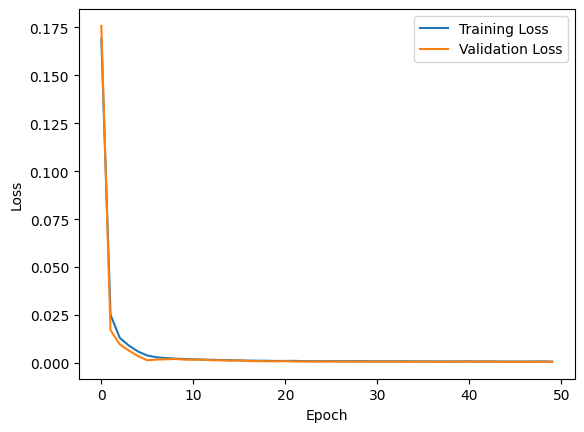

Model saved at: lstm_model.pth


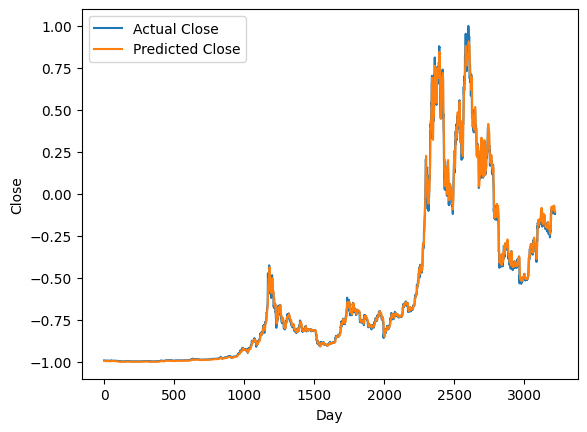

In [14]:
import numpy as np
import pandas as pd
import requests
import csv
from datetime import datetime, date, timedelta
import time
import json
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



batch = 16
num_epochs = 50
learning_rate = 0.001

# Function to get yesterday's date
def get_yesterday_date():
    yesterday = date.today() - timedelta(days=1)
    return yesterday.strftime('%Y-%m-%d')

# Function to construct download URL
def construct_download_url(ticker, period1, period2, interval='monthly'):
    def convert_to_seconds(period):
        datetime_value = datetime.strptime(period, '%Y-%m-%d')
        total_seconds = int(time.mktime(datetime_value.timetuple())) + 86400
        return total_seconds

    try:
        interval_reference = {'daily': '1d', 'weekly': '1wk', 'monthly': '1mo'}
        _interval = interval_reference.get(interval)
        if _interval is None:
            print('Interval code is incorrect')
            return
        p1 = convert_to_seconds(period1)
        p2 = convert_to_seconds(period2)
        url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={p1}&period2={p2}&interval={_interval}&filter=history'
        return url
    except Exception as e:
        print(e)
        return

# Function to create a DataFrame for LSTM
def dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)
    return df

# Function to train one epoch
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index+1}, Loss: {avg_loss_across_batches:.3f}')
            running_loss = 0.0
    print()

# Function to validate one epoch
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print(f'Val Loss: {avg_loss_across_batches:.3f}')
    print('***************************************************')
    print()

# User input for crypto name
coinName = input("Enter crypto name: ")

# Fetching coin information
url = "https://api.coingecko.com/api/v3/coins/list"
response = requests.get(url)
data = response.json()
ticker = next((coin["symbol"] for coin in data if coin["name"].lower() == coinName.lower()), "")

# Check if coin is found
if not ticker:
    print("Coin not found")
    exit()

# Get yesterday's date
yesterday_date = get_yesterday_date()

# Construct ticker for query
ticker = ticker.upper() + '-USD'

# Construct download URL
query_url = construct_download_url(ticker, '1950-01-03', yesterday_date, 'daily')

# Read data from CSV
df = pd.read_csv(query_url)
df.set_index('Date', inplace=True)

# Save dataset as CSV and JSON
csvTitle = ticker + ' Historical Data.csv'
df.to_csv(csvTitle)
jsonTitle = ticker + '.json'
with open(jsonTitle, 'w') as f:
    f.write(json.dumps(df.T.to_dict(), indent=4))

# Read data from CSV again
data = pd.read_csv(csvTitle)
data = data[['Date', 'Close']]

# Create DataFrame for LSTM
lookback = 7
shifted_df = dataframe_for_lstm(data, lookback)

# Convert DataFrame to numpy array
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df.to_numpy())

# Prepare input and output for LSTM
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
X = dc(np.flip(X, axis=1))

# Split the dataset
split_index = int(len(X) * 0.95)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for LSTM
X_train, X_test = X_train.reshape((-1, lookback, 1)), X_test.reshape((-1, lookback, 1))
y_train, y_test = y_train.reshape((-1, 1)), y_test.reshape((-1, 1))

# Convert to PyTorch tensors
X_train, y_train, X_test, y_test = (
    torch.tensor(X_train).float(),
    torch.tensor(y_train).float(),
    torch.tensor(X_test).float(),
    torch.tensor(y_test).float(),
)

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Instantiate and move model to device
model = LSTM(1, 4, 1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model.to(device)

# Training parameters
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Create datasets and loaders
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model_save_path = 'lstm_model.pth'

train_losses = []
val_losses = []

# Train the model
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

    # Calculate and store training and validation losses
    with torch.no_grad():
        model.eval()
        train_loss = loss_function(model(X_train.to(device)), y_train.to(device)).item()
        val_loss = loss_function(model(X_test.to(device)), y_test.to(device)).item()
        train_losses.append(train_loss)
        val_losses.append(val_loss)

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), model_save_path)
print(f"Model saved at: {model_save_path}")

# Make predictions on training set
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

# Plot training set predictions
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
# start_index = 1500  # Choose the starting index of the close-up
# end_index = 2200    # Choose the ending index of the close-up
# plt.ylim(-1, -0.25)
# plt.xlim(start_index, end_index)
plt.show()


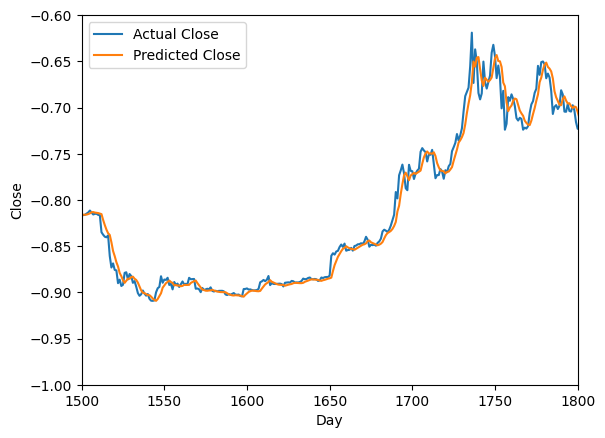

In [15]:
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
start_index = 1500  # Choose the starting index of the close-up
end_index = 1800   # Choose the ending index of the close-up
plt.ylim(-1, -0.6)
plt.xlim(start_index, end_index)
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
with torch.no_grad():
    predicted_test = model(X_test.to(device)).to('cpu').numpy()

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predicted_test)
print(f'Mean Squared Error (MSE) on test set: {mse:.4f}')

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predicted_test)
print(f'Mean Absolute Error (MAE) on test set: {mae:.4f}')


Mean Squared Error (MSE) on test set: 0.0006
Mean Absolute Error (MAE) on test set: 0.0185


In [29]:
import requests
from datetime import datetime, timezone
import pytz

def get_last_seven_closing_prices_and_timestamps(coin_id):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/ohlc'
    params = {
        'vs_currency': 'usd',
        'days': '1',
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Extracting closing prices and timestamps
    closing_prices = [entry[4] for entry in data]

    # Ensure timestamps are valid numbers before attempting conversion
    timestamps = [entry[0] if str(entry[0]).isdigit() else 0 for entry in data]

    # Using the America/New_York time zone with an offset of -8 hours
    local_tz = pytz.timezone('America/New_York')

    # Converting timestamps to human-readable format in the America/New_York time zone with an offset of -8 hours
    human_readable_timestamps = [datetime.utcfromtimestamp(int(timestamp) / 1000).replace(tzinfo=timezone.utc).astimezone(local_tz).strftime('%Y-%m-%d %H:%M:%S') for timestamp in timestamps]

    recent_closing_prices = closing_prices[::-1][:9]
    recent_human_readable_timestamps = human_readable_timestamps[::-1][:9]

    print(recent_closing_prices)

    recent_closing_prices = recent_closing_prices[::-1][:-1]
    recent_human_readable_timestamps = recent_human_readable_timestamps[::-1][:-1]

    return recent_closing_prices, recent_human_readable_timestamps

# Example usage
coin_id = 'bitcoin'  # Replace with the desired coin ID
recent_closing_prices, human_readable_timestamps = get_last_seven_closing_prices_and_timestamps(coin_id)

# Printing the 7 most recent closing prices and timestamps in the America/New_York time zone with an offset of -8 hours
for price, timestamp in zip(recent_closing_prices, human_readable_timestamps):
    print(f"Closing Price: {price} USD, Timestamp: {timestamp}")


['u']


In [28]:
print(recent_closing_prices[::-1])


[]


In [19]:
import numpy as np
import torch

# Assuming loaded_model and other necessary components are already loaded

# Load the model architecture
loaded_model = LSTM(1, 4, 1)

# Load the saved model state dictionary
state_dict = torch.load(model_save_path)

# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)

input_prices =  recent_closing_prices
print(input_prices)

# Apply the same Min-Max scaling as in the training data
scaler = MinMaxScaler(feature_range=(-1, 1))
input_array = scaler.fit_transform(np.array(input_prices).reshape(-1, 1)).reshape(1, -1, 1)
#print(input_array)

# Convert the NumPy array to a PyTorch tensor
input_tensor = torch.tensor(input_array).float()

# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# Set the model to evaluation mode
model.eval()

# Make the prediction
with torch.no_grad():
    predicted_price = loaded_model(input_tensor).item()

# Inverse transform the predicted price to the original scale
predicted_price_original_scale = scaler.inverse_transform(np.array([[predicted_price]]))[0, 0]

print(f"The predicted next closing price is: {predicted_price_original_scale:.2f}")


[44050.0, 44057.0, 44158.0, 44155.0, 44054.0, 44252.0, 44198.0, 44176.0]
The predicted next closing price is: 44198.05
